## Did Louisville recover from recession more quickly than similar cities?

First we'll import libraries. The altair package can be installed this way: conda install altair --channel conda-forge

To display in the notebook, you will also need to: conda install -c conda-forge altair vega_datasets notebook vega

For additional install troubleshooting, see: https://altair-viz.github.io/getting_started/installation.html#installation-notebook

In [1]:
import sqlite3
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Reading in an excel sheet of jobs related data for Louisville and for peer cities (source: Greater Louisville Project). You can use the Download Data button on this website to download a copy: http://greaterlouisvilleproject.org/deep-drivers-of-change/21st-century-jobs/

In [17]:
jobs_df = pd.read_excel('GLP-Codebook.xlsx', 'Jobs County', index_col=None, na_values=['NA'])

In [18]:
jobs_df

,city,county,state,FIPS,year,current,baseline,median_earnings,income_inequality,median_household_income,personal_income_per_cap,unemployment
0,Birmingham,Jefferson,AL,1073,2005,1,1,26654.000000,NaN,41821.000000,37711.000000,4.400000
1,Birmingham,Jefferson,AL,1073,2006,1,1,27026.000000,NaN,41731.000000,40093.000000,4.000000
2,Birmingham,Jefferson,AL,1073,2007,1,1,29234.000000,NaN,44908.000000,41109.000000,3.900000
3,Birmingham,Jefferson,AL,1073,2008,1,1,30284.000000,NaN,46269.000000,42313.000000,5.400000
4,Birmingham,Jefferson,AL,1073,2009,1,1,28820.000000,NaN,43312.000000,40596.000000,10.800000
5,Birmingham,Jefferson,AL,1073,2010,1,1,26796.000000,16.989401,41740.000000,42248.000000,10.300000
6,Birmingham,Jefferson,AL,1073,2011,1,1,27467.000000,17.320135,42053.000000,43241.000000,9.300000
7,Birmingham,Jefferson,AL,1073,2012,1,1,30217.000000,17.830477,43967.000000,45118.000000,7.400000
8,Birmingham,Jefferson,AL,1073,2013,1,1,30259.000000,18.373020,45024.000000,44605.000000,6.700000
9,Birmingham,Jefferson,AL,1073,2014,1,1,29207.000000,18.529636,44852.000000,46426.000000,6.300000


Creating a sql database that can be queried from in the next step.

In [3]:
jobs_df.to_sql("jobs_table", sqlite3.connect("jobs.db"), if_exists = "replace")


### Mostly pandas, some SQL

Querying back just the unemployment, median earnings, and personal income per capita data by year and city. Only for cities that are currently peers

In [4]:
con = sqlite3.connect("jobs.db")
jobs_df = pd.read_sql_query("SELECT year, city, unemployment, median_earnings, personal_income_per_cap FROM jobs_table WHERE current = 1", con)
jobs_df.head()

,year,city,unemployment,median_earnings,personal_income_per_cap
0,2005,Birmingham,4.4,26654.0,37711.0
1,2006,Birmingham,4.0,27026.0,40093.0
2,2007,Birmingham,3.9,29234.0,41109.0
3,2008,Birmingham,5.4,30284.0,42313.0
4,2009,Birmingham,10.8,28820.0,40596.0


Making year into a datetime, subsetting to just Louisville, peers without Louisville, and finding mean of non-Louisville cities. Note: one nice thing about the groupby and mean code is that it doesn't change for multiple variables or require a loop. I changed the query above to include more than just 'unemployment' as shown in class, but didn't have to change the groupby.

In [5]:
jobs_df['year'] = pd.to_datetime(jobs_df['year'], format = "%Y") #year column as datetime instead of character
lou_df = jobs_df[(jobs_df.city == "Louisville")] # splitting the dataframe
peer_df = jobs_df[(jobs_df.city != "Louisville")]
mean_df = peer_df.groupby('year', as_index = False).mean() #groupby and aggregate
mean_df['city'] = "Peers"
df = mean_df.append(lou_df)
df


/home/nate/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,city,median_earnings,personal_income_per_cap,unemployment,year
0,Peers,27344.883971,37369.002164,5.183355,2005-01-01
1,Peers,27052.563282,40136.556310,4.729172,2006-01-01
2,Peers,28249.803964,41538.609774,4.590456,2007-01-01
3,Peers,29154.220904,43851.874204,5.523364,2008-01-01
4,Peers,27835.079778,41057.541016,9.032107,2009-01-01
5,Peers,27870.376521,41672.174361,9.070599,2010-01-01
6,Peers,28502.883857,44240.026675,8.200243,2011-01-01
7,Peers,29102.076666,46801.353146,7.067662,2012-01-01
8,Peers,29559.644521,46214.223862,6.670672,2013-01-01
9,Peers,29630.393830,48428.054048,5.589567,2014-01-01


This next code chunk loops over the three variables and graphs them. Jupyter notebook limits visuals to one chart per cell (if someone knows how to override this let me know), so I've saved the charts as separate .html files. They're saved in the working directory.



In [6]:
var_list = ['unemployment', 'median_earnings', 'personal_income_per_cap']
for var in var_list:
    chart = alt.Chart(df).mark_line().encode(
    x='year',
    y= var,
    color='city') #group data and lines by this variable
    chart.save(var+'_chart.html') #saves to working directory as 'unemployment_chart.html', etc. for each variable


What if we want the charts in the notebook though? One workaround is to write a function that we can then call in separate cells. This function is specific to our current dataframe - the only thing that changes is the name of the column. It looks a lot like the for loop, but instead of automatically looping through a list of variables, we have to pass the variable names to the function. One advantange though is in the possible extenions we could make in the future (e.g. a title for the graph or different axis labels could be an argument that gets passed to a function and so can vary graph by graph).

In [7]:
def make_graph (var):
    chart = alt.Chart(df).mark_line().encode(
        x='year',
        y= var,
        color='city'
    )
    return chart

#### Unemployment

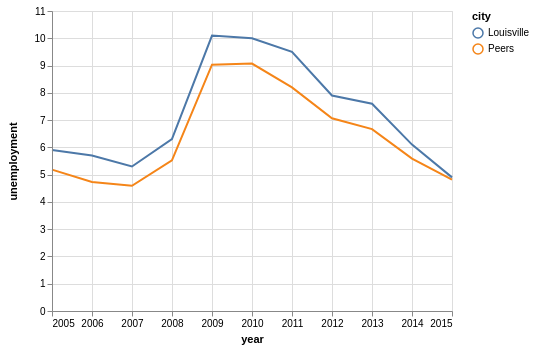

In [9]:
make_graph('unemployment')

## This is commentary
These are _italics_
- this is
- a list
- of all the things


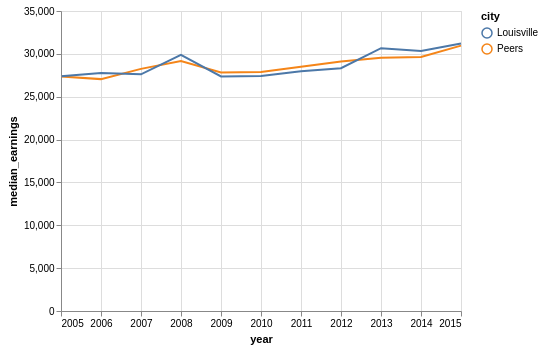

In [10]:
make_graph('median_earnings')

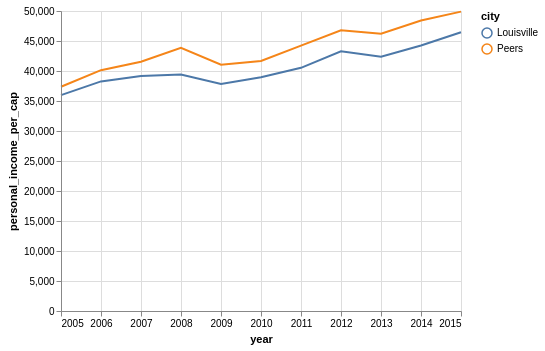

In [11]:
make_graph('personal_income_per_cap')

#### Mostly SQL, some pandas

Now let's try a more SQL based approach. We'll just worry about unemployment for now.

First, pull down Louisville data and rename

In [12]:
lou_df = pd.read_sql_query("""
SELECT year, unemployment as 'lou_unemployment'
FROM jobs_table 
WHERE current = 1 AND city = 'Louisville'
""", con)
lou_df

,year,lou_unemployment
0,2005,5.9
1,2006,5.7
2,2007,5.3
3,2008,6.3
4,2009,10.1
5,2010,10.0
6,2011,9.5
7,2012,7.9
8,2013,7.6
9,2014,6.1


Then pull down peer data, rename, and groupby.

In [13]:
peer_df = pd.read_sql_query("""
SELECT year, avg(unemployment) as 'peer_unemployment'
FROM jobs_table 
WHERE current = 1 AND city != 'Louisville'
GROUP BY year
""", con)
peer_df

,year,peer_unemployment
0,2005,5.183355
1,2006,4.729172
2,2007,4.590456
3,2008,5.523364
4,2009,9.032107
5,2010,9.070599
6,2011,8.200243
7,2012,7.067662
8,2013,6.670672
9,2014,5.589567


Depending on how complex the work is you can save these new tables back into the same database for future queries. Probably not necessary in this case

In [14]:
peer_df.to_sql("peer_unemp_table", sqlite3.connect("jobs.db"), if_exists = "replace")
lou_df.to_sql("lou_unemp_table", sqlite3.connect("jobs.db"), if_exists = "replace")

Then we can join the two tables in SQL. Note that when dealing with multiple tables we can specify the field we're trying to pull with table_name.field_name (e.g. lou_unemp_table.year).

In [15]:
df = pd.read_sql_query("""
SELECT lou_unemp_table.year, lou_unemployment, peer_unemployment
FROM lou_unemp_table
JOIN peer_unemp_table
ON lou_unemp_table.year = peer_unemp_table.year
""", con)
df

,year,lou_unemployment,peer_unemployment
0,2005,5.9,5.183355
1,2006,5.7,4.729172
2,2007,5.3,4.590456
3,2008,6.3,5.523364
4,2009,10.1,9.032107
5,2010,10.0,9.070599
6,2011,9.5,8.200243
7,2012,7.9,7.067662
8,2013,7.6,6.670672
9,2014,6.1,5.589567


Just for reference because the pandas code above appends rows to the dataframe, it is also possible to execute SQL-style joins in pandas

In [16]:
df = pd.merge(lou_df, peer_df, how = 'outer', left_on = ['year'], right_on = ['year'])
df

,year,lou_unemployment,peer_unemployment
0,2005,5.9,5.183355
1,2006,5.7,4.729172
2,2007,5.3,4.590456
3,2008,6.3,5.523364
4,2009,10.1,9.032107
